# Cambiar los datos.
Para el modelo de Lodka Volterra, cambiaremos los datos a las fechas de los casos del covid e y_1 y_2 se convertiran en total de infectados y muertos respectivamente.

Cambiaremos `lynx.txt` por `covid.txt` en el mismo formato.

In [4]:
#######################################################################################################
## Estimation Lynx-Hare dynamics using Lotka-Volterra equation                                       ##   
## Estimates based on QL-ODE-P-splines (Frasso, Jaeger and Lambert, 2015)                            ##
#######################################################################################################

#-------------------------------------------- library -------------------------------------------------#

rm(list = ls()); graphics.off(); cat("\014")
library(splines)
library(Matrix)
library(spam)
library(deSolve)

#------------------------------------- source files ---------------------------------------------------#

source("basis_array.R")
source("functions_to_optimize.R")
source("penalty_function.R")

#------------------------------------------ data and time ---------------------------------------------#

dat = read.delim("covid.txt", header = F)
dat = dat[16:36, ]

t_obs = seq(0, 20, len = nrow(dat))
n = length(t_obs)

y_obs_1 = dat[, 2] 
y_obs_2 = dat[, 3] 
y_obs = c(y_obs_1, y_obs_2)

N_obs = n * 2

min_t = min(t_obs)
max_t = max(t_obs)


In [6]:

#------------------------------------- Basis matrices -------------------------------------------------#

length_t = 1e3 
seq_t = seq(min_t, max_t, length = length_t)
ndt = 200

B_seq_t = basis_array(x = seq_t, xl = min_t, xr = max_t, ndx = ndt, deg = 3, max_derivs = 2, sparse = TRUE)
for (j in 1:length(B_seq_t))
{
B_seq_t[[j]] = as.spam(as.matrix(B_seq_t[[j]]))
}


In [7]:
#------------------------------------- stoping rules --------------------------------------------------#

tol_gamma = 1e-4
tol_ck = 1e-4
tol_theta_tau = 1e-4


In [8]:
#-------------------------------- design matrix and diff pen ------------------------------------------#

B = basis_array(x = t_obs, xl = min_t, xr = max_t, ndx = ndt, deg = 3, max_derivs = 1, sparse = TRUE)
B_0 = as.spam(as.matrix(B[[1]]))
t_B_0 = t(B_0)

tB_B = t_B_0 %*% B_0

tB_y = t_B_0 %*% cbind(y_obs_1, y_obs_2)

M = dim(tB_B)[2]

D = diff(diag(M), diff = 2)
tD_D = t(D) %*% D


In [9]:
#------------------ Initial smoothing raw data and initial parameters ---------------------------------#

# smoothing for x1 and x2

las = seq(-1, 8, by = .5)
cv = ed = las * 0
i = 1

for(la in las)
{
  lam = 10 ^ la
  solve_A = solve(tB_B +  lam * tD_D)
  cy = solve_A %*% tB_y
  ed[i] = sum(diag(B_0 %*% solve_A %*% t_B_0))
  rss = sum((y_obs - B_0 %*% cy) ^ 2)
  cv[i] = rss/((N_obs - ed[i]) ^ 2)
  i = i + 1
}

lam_opt = 10 ^ las[which.min(cv)]
ck = c(solve(tB_B +  lam_opt * tD_D, tB_y))
tau_in = (N_obs - ed[which.min(cv)])/sum((y_obs - B_0 %*% matrix(ck, ncol = 2))^2)


En la siguiente linea de código el algoritmo se queda dentro del ciclo while. La pregunta es ¿Mi computador no es tan potente?, ¿Hay algo que haga que no salga del ciclo while?

In [13]:
#--------------------------------- Quasi ODE-P-spline ---------------------------------------------------#

pars = c(1, 1, 1, 1, 1) # initial parameters as in section 5.2
i = 1
ck = cbind(ck, NULL)
       
theta_tau = c(pars)

crit_gamma = crit_ck = crit_theta_tau = 1
gamma = 1e4

while(((crit_ck > tol_ck) | (crit_gamma > tol_gamma) | (crit_theta_tau > tol_theta_tau)) && (i < 100))
{
  theta_tau_old = theta_tau
  zandpen = c_hat_function(theta = theta_tau[-length(theta_tau)],
                           tau = theta_tau[length(theta_tau)],
                           gamma,
                           ck = ck[, i],
                           length_t,
                           seq_t,
                           B_seq_t,
                           regul = 0.0)

  z = zandpen[[1]]
  pen = zandpen[[2]]
  t_z = t(z)

  y_star = B_0 %*% matrix(z, ncol = 2)
  PEN = (t_z %*% pen $ R %*% z + 2 * t_z %*% pen $ r + pen $ l) 
 
  A = as.matrix(gamma * pen $ R +
                rbind(cbind(tB_B  * theta_tau[length(theta_tau)], tB_B * 0),
                cbind(tB_B * 0, tB_B * theta_tau[length(theta_tau)])))
  solve_A = solve(A, tol = 1e-50)

  ed_1 = sum(diag(B_0 %*% solve_A[1:M, 1:M] %*% (theta_tau[length(theta_tau)] * t_B_0)))
  ed_2 = sum(diag(B_0 %*% solve_A[M + 1:M, M + 1:M] %*% (theta_tau[length(theta_tau)] * t_B_0)))

  theta_tau[length(theta_tau)] = (N_obs - (ed_1 + ed_2)) / sum((y_obs - c(y_star)) ^ 2)

  den = c(PEN / (ed_1 + ed_2))

  gamma_new = 1 / (den + 1e-15)

  crit_gamma = abs((gamma - gamma_new) / gamma)
  gamma = gamma_new

  ck = cbind(ck, z)
  crit_ck = max(abs((ck[, i] - z) / ck[, i]))

  optim_parm = optim(par = theta_tau[-length(theta_tau)],
                     fn = H_fun,
                     tau =  theta_tau[length(theta_tau)],
                     gamma = gamma,
                     ck = z,
                     length_t = length_t,
                     seq_t = seq_t,
                     B_seq_t = B_seq_t,
                     regul = 0.0,
                     method = "BFGS",
                     control = list(fnscale = -1, trace = FALSE),
                     hessian = TRUE)

  theta_tau[-length(theta_tau)] = optim_parm $ par
  FIM = solve(-optim_parm $ hessian)

  crit_theta_tau = max(abs((theta_tau - theta_tau_old) / theta_tau_old))

  cat('iteration:', i,'\n')
  cat('\t', 'crit_gamma:', round(crit_gamma, 8), '\n')
  cat('\t', 'crit_ck:', round(crit_ck, 8), '\n')
  cat('\t', 'crit_theta_tau:', round(crit_theta_tau, 8), '\n')
  cat('\t', 'gamma:', round(gamma, 8), '\n')
  cat('\t', 'tau:', round(tail(theta_tau, n = 1), 8), '\n')
  cat('\t', 'theta:', head(theta_tau, n = -1), '\n')
  
  i = i+1
}


iteration: 1 
	 crit_gamma: 0.9999564 
	 crit_ck: 1.520148 
	 crit_theta_tau: 3.148387 
	 gamma: 0.4354823 
	 tau: 3.2e-07 
	 theta: 0.5543694 -2.148387 0.3178673 2.686912 
iteration: 2 
	 crit_gamma: 0.9997262 
	 crit_ck: 8.787551 
	 crit_theta_tau: 24.17883 
	 gamma: 0.00011925 
	 tau: 3.6e-07 
	 theta: 0.4950072 -0.2214412 -7.367793 4.944586 
iteration: 3 
	 crit_gamma: 0.7639796 
	 crit_ck: 4.056261 
	 crit_theta_tau: 1.30302 
	 gamma: 2.815e-05 
	 tau: 7.5e-07 
	 theta: -0.149997 -0.05088732 -6.782361 5.651707 
iteration: 4 
	 crit_gamma: 0.509889 
	 crit_ck: 1.14633 
	 crit_theta_tau: 22.6479 
	 gamma: 1.379e-05 
	 tau: 1.763e-05 
	 theta: 0.1964102 -8.517441e-05 16.66569 0.07271039 
iteration: 5 
	 crit_gamma: 7.95157 
	 crit_ck: 4.374357 
	 crit_theta_tau: 8.55917 
	 gamma: 0.00012348 
	 tau: 9.271e-05 
	 theta: 0.7222893 0.0006438478 15.69631 0.07724852 
iteration: 6 
	 crit_gamma: 0.1361022 
	 crit_ck: 2.912385 
	 crit_theta_tau: 0.6067696 
	 gamma: 0.00014029 
	 tau: 9.243e-

In [15]:
#--------------------------------- plot and approx. std errors ----------------------------------------#

std_err = sqrt(diag(FIM)) # approximate parameter std. error
lev = 0.99
alp = qnorm(1-(1-lev)/2)
sigma = sqrt(1/theta_tau[length(theta_tau)])

par(mfcol = c(2, 1), mar = c(3.5, 3.5, 2, 1), cex.main = 1, mgp = c(2, 0.8, 0))

Warning message in sqrt(diag(FIM)):
“NaNs produced”


In [17]:
A = as.matrix(gamma * pen $ R +
                rbind(cbind(tB_B  * theta_tau[length(theta_tau)], tB_B * 0),
                      cbind(tB_B * 0, tB_B * theta_tau[length(theta_tau)])))
solve_A = sigma^2 * solve(A, tol = 1e-50)     

bounds = B_seq_t[[1]] %*% solve_A[1:M, 1:M] %*% t(B_seq_t[[1]] * theta_tau[5])

low_bound = B_seq_t[[1]] %*% ck[1:M, i] - alp * sqrt(diag(bounds))
up_bound = B_seq_t[[1]] %*% ck[1:M, i] + alp * sqrt(diag(bounds))   

ERROR: Error in lines(times + 1900, out[, "x1"], col = 1, lty = 2, lwd = 2): object 'times' not found


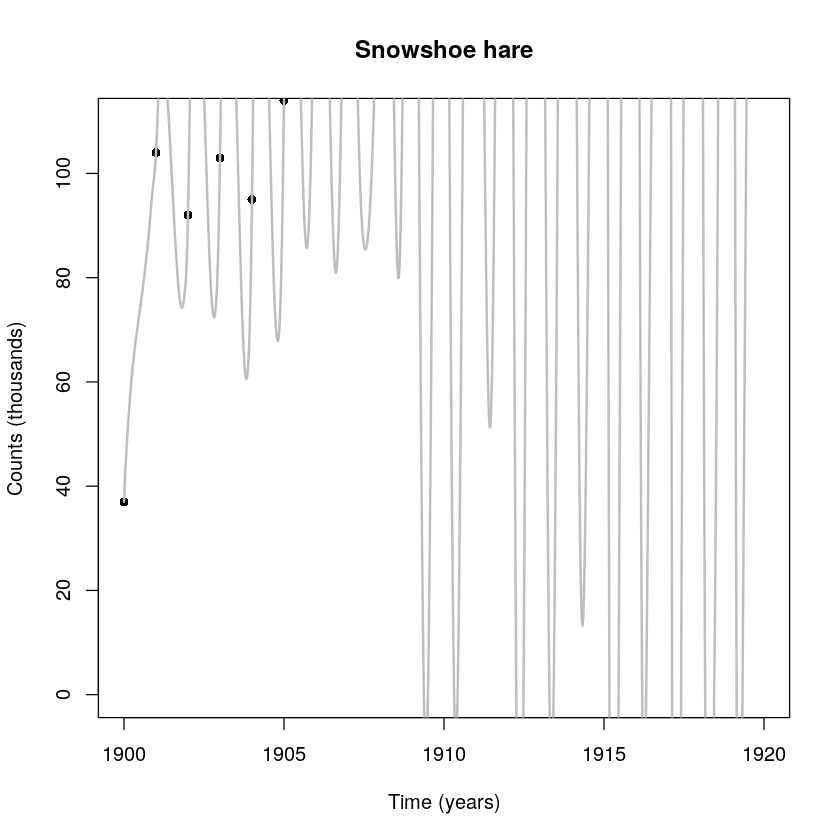

In [19]:
plot(t_obs + 1900, y_obs_1, main = "Snowshoe hare",
     xlab = "Time (years)", ylab = "Counts (thousands)", ylim = c(0, 110),
     pch = 16, cex = 1, col = 1)
lines(seq_t + 1900, B_seq_t[[1]] %*% ck[1:M, i], lwd = 2, col = 8)
lines(times + 1900, out[, "x1"], col = 1, lty = 2, lwd = 2)
lines(seq_t + 1900, low_bound, col = 2, lty = 2)
lines(seq_t + 1900, up_bound, col = 2, lty = 2)

points(t_obs + 1900, y_obs_1, col = 1, pch = 16)
legend("top", c("Observations", "Estimated hare dynamics", "Numerical solution",
                    "Std. Err. bands"),
       col = c("black", "gray", "black", "red"), pch = c(16, -1, -1, -1),
       lty = c(0, 1, 2, 2), lwd = c(0, 2, 2, 1), box.lty = 0, cex = 0.8)

bounds = B_seq_t[[1]]  %*% solve_A[M + 1:M, M + 1:M] %*% t(B_seq_t[[1]] * theta_tau[5])

low_bound = B_seq_t[[1]] %*% ck[M + 1:M, i] - alp * sqrt(diag(bounds))
up_bound = B_seq_t[[1]] %*% ck[M + 1:M, i] + alp * sqrt(diag(bounds)) 

ERROR: Error in lines(times + 1900, out[, "x2"], col = 1, lty = 2, lwd = 2): object 'times' not found


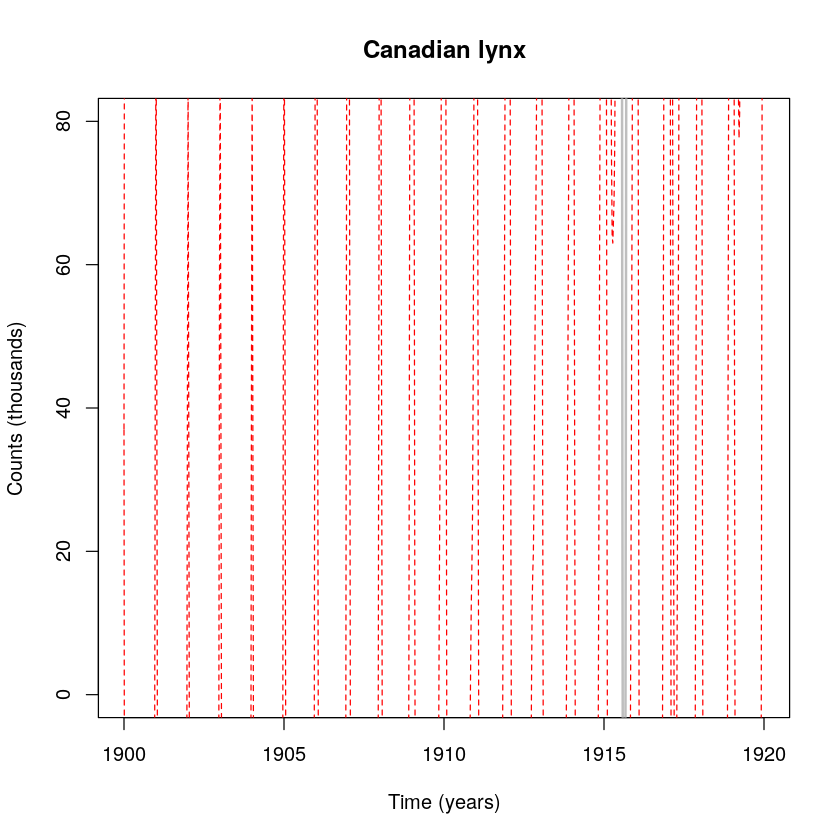

In [20]:
plot(t_obs + 1900, y_obs_2, main = "Canadian lynx",
     xlab = "Time (years)", ylab = "Counts (thousands)", ylim = c(0, 80),
     pch = 16, cex = 1, col = 1)
lines(seq_t + 1900, B_seq_t[[1]] %*% ck[M + 1:M, i], lwd = 2, col = 8)
lines(seq_t + 1900, low_bound, col = 2, lty = 2)
lines(seq_t + 1900, up_bound, col = 2, lty = 2)

lines(times + 1900, out[, "x2"], col = 1, lty = 2, lwd = 2)
points(t_obs + 1900, y_obs_2, pch = 16, col = 1)
legend("top", c("Observations", "Estimated lynx dynamics", "Numerical solution",
                    "Std. Err. bands"),
       col = c("black", "gray", "black", "red"), pch = c(16, -1, -1, -1),
       lty = c(0, 1, 2, 2), lwd = c(0, 2, 2, 1), box.lty = 0, cex = 0.8)